In [1]:
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import joblib
import os
from sklearn.model_selection import train_test_split

In [2]:
path=os.path.join("..", "app", "model.joblib")
best_pipeline = joblib.load(path)

path=os.path.join("..","data", "processed", "telco_churn_cleaned.csv")
df=pd.read_csv(path, delimiter=",")

y=df['Churn']
X=df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [ ]:
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

cat_to_int = {}
int_to_cat = {}
X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

for c in cat_cols:
    cats = sorted(X_train[c].dropna().unique().tolist())
    c_map = {cat: i for i, cat in enumerate(cats)}
    cat_to_int[c] = c_map
    int_to_cat[c] = {i: cat for cat, i in c_map.items()}
    X_train_enc[c] = X_train[c].map(c_map).astype(float)  
    X_test_enc[c]  = X_test[c].map(c_map).astype(float)


cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
cat_names = {X_train.columns.get_loc(c): [int_to_cat[c][i] for i in sorted(int_to_cat[c].keys())]
             for c in cat_cols}


explainer = LimeTabularExplainer(
    training_data=X_train_enc.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No churn', 'Churn'],
    categorical_features=cat_idx,
    categorical_names=cat_names,
    discretize_continuous=True,
    random_state=42,
    mode='classification'
)

def predict_fn(x):
    df_num = pd.DataFrame(x, columns=X_train.columns)
    df_dec = df_num.copy()
    for c in cat_cols:
        rev = int_to_cat[c]
        df_dec[c] = df_num[c].round().astype(int).map(rev)  # asegura enteros válidos
    return best_pipeline.predict_proba(df_dec)

Caso 1 — True Positive (pred=1, real=1) (idx=3524) | Prob(Churn)=0.732
  Contract=Month-to-month: 0.1712
  InternetService=Fiber optic: 0.1087
  PaperlessBilling=Yes: 0.0487
  TechSupport=No: 0.0408
  PhoneService=Yes: -0.0404
  9.00 < tenure <= 29.00: 0.0359
  OnlineSecurity=No: 0.0358
  StreamingMovies=Yes: 0.0295
  Dependents=No: 0.0248
  SeniorCitizen > 0.00: 0.0230


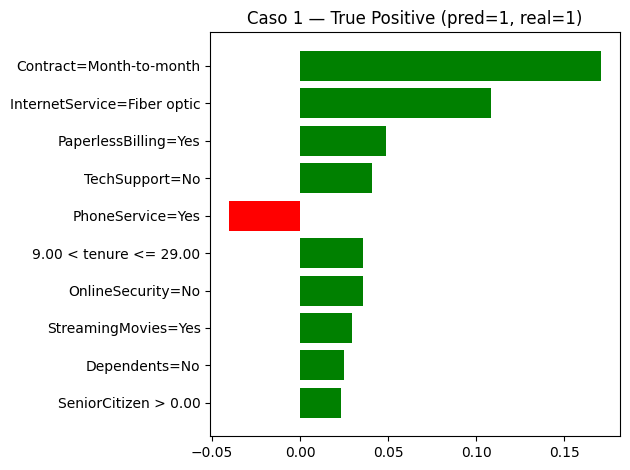

Caso 2 — False Negative (pred=0, real=1) (idx=1639) | Prob(Churn)=0.398
  Contract=Month-to-month: 0.1801
  InternetService=DSL: -0.0606
  PaymentMethod=Electronic check: 0.0577
  PaperlessBilling=Yes: 0.0515
  PhoneService=Yes: -0.0468
  OnlineSecurity=No: 0.0378
  StreamingMovies=No: -0.0339
  SeniorCitizen > 0.00: 0.0321
  TechSupport=No: 0.0285
  StreamingTV=No: -0.0270


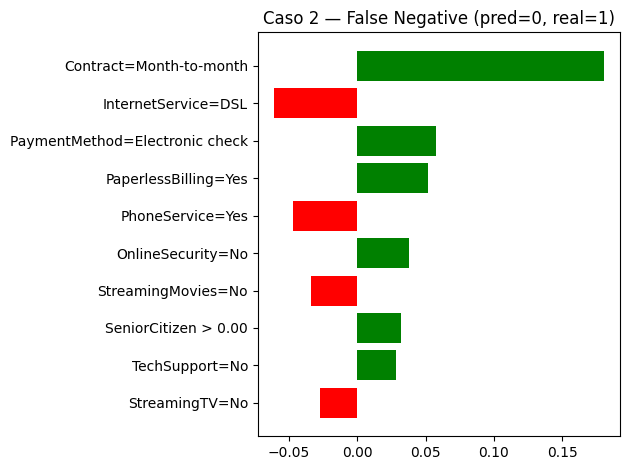

Caso 3 — False Positive (pred=1, real=0) (idx=2280) | Prob(Churn)=0.895
  Contract=Month-to-month: 0.1805
  tenure <= 9.00: 0.1573
  InternetService=Fiber optic: 0.1165
  MonthlyCharges > 90.00: 0.0831
  PaperlessBilling=Yes: 0.0485
  PhoneService=Yes: -0.0443
  TechSupport=Yes: -0.0395
  OnlineSecurity=No: 0.0376
  SeniorCitizen > 0.00: 0.0339
  StreamingMovies=Yes: 0.0309


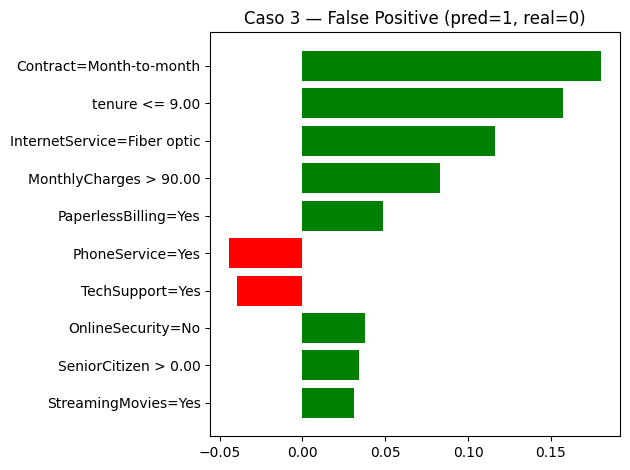

In [5]:
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba > 0.5).astype(int)

def first_index(mask):
    idx = X_test[mask].index
    return int(idx[0]) if len(idx) else int(X_test.index[0])

idx_tp = first_index((y_test_pred == 1) & (y_test == 1))
idx_fn = first_index((y_test_pred == 0) & (y_test == 1))
idx_fp = first_index((y_test_pred == 1) & (y_test == 0))

cases = [
    ("Caso 1 — True Positive (pred=1, real=1)", idx_tp),
    ("Caso 2 — False Negative (pred=0, real=1)", idx_fn),
    ("Caso 3 — False Positive (pred=1, real=0)", idx_fp),
]

import matplotlib.pyplot as plt

def explain_index(title, idx, top_features=10):
    row_enc = X_test_enc.loc[idx].values  
    exp = explainer.explain_instance(
        data_row=row_enc,
        predict_fn=predict_fn,
        num_features=top_features
    )
    print(title, f"(idx={idx}) | Prob(Churn)={y_test_proba[X_test.index.get_loc(idx)]:.3f}")
    for f, w in exp.as_list():
        print(f"  {f}: {w:.4f}")
    fig = exp.as_pyplot_figure()
    plt.title(title); plt.tight_layout(); plt.show()

for t, i in cases:
    explain_index(t, i, top_features=10)


* **Caso 1 (TP, prob=0.73):** empujan al churn el **contrato Month-to-month**, **Fiber optic**, **PaperlessBilling=Yes** y **TechSupport=No**; un **tenure bajo-medio** también suma riesgo. Solo **PhoneService=Yes** resta un poco.
* **Caso 2 (FN, prob=0.40):** hay señales de riesgo (**Month-to-month**, **Electronic check**, **PaperlessBilling=Yes**, **OnlineSecurity=No**), pero factores como **DSL**, **PhoneService=Yes** y **Streaming** “No” reducen la probabilidad; el modelo se quedó corto y lo clasificó como 0.
* **Caso 3 (FP, prob=0.90):** fuerte empuje por **Month-to-month**, **tenure muy bajo**, **Fiber optic**, **MonthlyCharges altos** y **OnlineSecurity=No**; pese a mitigadores (**PhoneService=Yes**, **TechSupport=Yes**), el modelo sobreestima el riesgo.
